<a href="https://colab.research.google.com/github/kashish049/SMS-SPAM-CLASSIFIER/blob/main/sms_spam_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [4]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 2. Load and Explore the Dataset
The UCI SMS Spam Collection dataset is used. You can download it from kaggle.

In [7]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving sms_spam_collection.csv to sms_spam_collection.csv


In [8]:
# Step 1: Load the dataset
df = pd.read_csv('sms_spam_collection.csv', encoding='ISO-8859-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
#df['label'] = df['label'].map({'ham': 0, 'spam': 1})
# df = df.sample(frac=0.2, random_state=42)  # Use 20% of the data for now


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


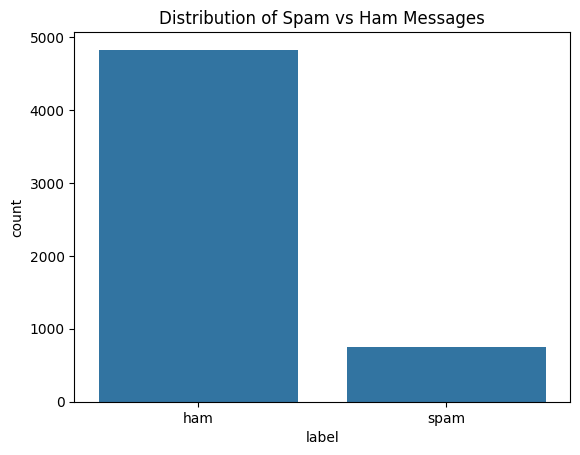

In [9]:
# Check basic info and data distribution
print(df.info())
print(df.head())

# Plot the label distribution
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam vs Ham Messages')
plt.show()

# 3. Data Cleaning and Preprocessing


*   Removing special characters and digits.
*   Tokenizing the message and removing stopwords.
*   Lemmatizing the text for normalization.









In [10]:
def clean_message(message):
    """Cleans and preprocesses the SMS message."""
    message = re.sub(r'\W', ' ', message)  # Remove non-word characters
    message = re.sub(r'\d', ' ', message)  # Remove digits
    message = message.lower()  # Convert to lowercase

    # Tokenize and remove stopwords
    tokens = message.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply cleaning to the entire dataset
df['cleaned_message'] = df['message'].apply(clean_message)


# 4. Feature Engineering using Skip-Gram Embeddings
We generate 1-grams and 2-grams (skip-gram embeddings) to capture informative word patterns.

In [11]:
# Create the vectorizer with skip-gram embeddings (1-skip-2-grams)
vectorizer = CountVectorizer(ngram_range=(1, 2))  # 1-grams and 2-grams
X = vectorizer.fit_transform(df['cleaned_message'])  # Transform messages into feature vectors
y = df['label'].map({'ham': 0, 'spam': 1})  # Encode labels as 0 (ham) and 1 (spam)

print(f'Feature Matrix Shape: {X.shape}')
df = df[df['label'].isin(['ham', 'spam'])]


Feature Matrix Shape: (5572, 36889)


# 5. Train-Test Split

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# 6. Model Building: SVM, KNN, and MLP
We train three models:

* SVM (Linear Support Vector Machine)
* KNN (K-Nearest Neighbors)
* MLP (Multilayer Perceptron)

In [13]:
# Train Linear SVM
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Train K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_model.fit(X_train, y_train)

# Train Multilayer Perceptron (MLP)
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=300, random_state=42)
mlp_model.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=300, random_state=42)

# 7. Weighted Voting-Based Prediction System
* We assign weights to each model based on prior performance.
* These weights influence the final consensus prediction.

In [14]:
# Define model weights (higher weights for more reliable models)
weights = {
    "SVM": 0.9,  # Highest weight for best performance
    "KNN": 0.8,
    "MLP": 0.85
}

# Dictionary of models
models = {
    "SVM": svm_model,
    "KNN": knn_model,
    "MLP": mlp_model
}

def predict_with_weighted_voting(models, message, weights):
    """Predicts whether a message is spam or ham using weighted voting."""
    cleaned = clean_message(message)  # Clean the input message
    features = vectorizer.transform([cleaned])  # Vectorize the message

    # Collect predictions and apply weights
    weighted_votes = defaultdict(float)
    predictions = {}

    for name, model in models.items():
        pred = model.predict(features)[0]  # Get prediction (0 or 1)
        result = "Spam" if pred == 1 else "Ham"
        predictions[name] = result

        # Add weighted vote
        weighted_votes[result] += weights[name]

    # Display individual predictions
    print("Individual Model Predictions:", predictions)

    # Determine the final prediction based on weighted votes
    final_prediction = max(weighted_votes, key=weighted_votes.get)
    return final_prediction

# Example usage
message = "Congratulations! You've won a free ticket to Bahamas. Call now!"
final_prediction = predict_with_weighted_voting(models, message, weights)
print(f"\nFinal Consensus Prediction: {final_prediction}")


Individual Model Predictions: {'SVM': 'Ham', 'KNN': 'Ham', 'MLP': 'Ham'}

Final Consensus Prediction: Ham


# 8. Evaluate Model Performance

In [15]:
# Function to evaluate and display model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Evaluate all models
print("SVM Performance:")
evaluate_model(svm_model, X_test, y_test)

print("\nKNN Performance:")
evaluate_model(knn_model, X_test, y_test)

print("\nMLP Performance:")
evaluate_model(mlp_model, X_test, y_test)


SVM Performance:
Accuracy: 0.980
Confusion Matrix:
[[1452    1]
 [  32  187]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1453
           1       0.99      0.85      0.92       219

    accuracy                           0.98      1672
   macro avg       0.99      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672


KNN Performance:
Accuracy: 0.933
Confusion Matrix:
[[1453    0]
 [ 112  107]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1453
           1       1.00      0.49      0.66       219

    accuracy                           0.93      1672
   macro avg       0.96      0.74      0.81      1672
weighted avg       0.94      0.93      0.92      1672


MLP Performance:
Accuracy: 0.976
Confusion Matrix:
[[1453    0]
 [  40  179]]
Classification Report:
              precision    recall  f1-sco

# 9.Confusion Matrix Visualization

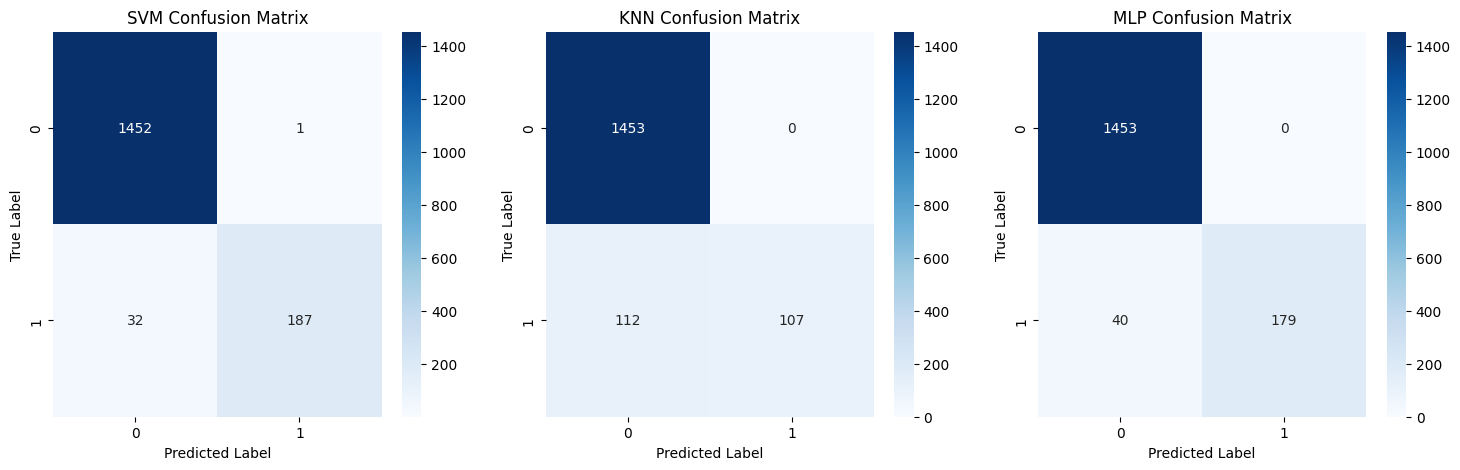

In [16]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, model, title in zip(axes, [svm_model, knn_model, mlp_model], ['SVM', 'KNN', 'MLP']):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{title} Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.show()


# Prediction Example: Spam Message

In [17]:
# Predict using the weighted voting system
spam_message = "You have won a $1000 Walmart gift card! Click here to claim your prize now."
spam_prediction = predict_with_weighted_voting(models, spam_message, weights)
print(f"Prediction for Spam Message: {spam_prediction}")


Individual Model Predictions: {'SVM': 'Spam', 'KNN': 'Ham', 'MLP': 'Spam'}
Prediction for Spam Message: Spam


In [18]:
# Predict using the weighted voting system
ham_message = "Don't forget to submit the project report by tomorrow morning."
ham_prediction = predict_with_weighted_voting(models, ham_message, weights)
print(f"Prediction for Ham Message: {ham_prediction}")


Individual Model Predictions: {'SVM': 'Ham', 'KNN': 'Ham', 'MLP': 'Ham'}
Prediction for Ham Message: Ham
